<a href="https://colab.research.google.com/github/praveentn/ml-repos/blob/master/Notebooks/QML/003-Cirq-Quantum_Hybrid_Model_Training_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Generating & training hybrid models

I hand you a quantum circuit with some free parameters and then I hand you some samples from that quantum circuit at specific parameter values, but I don't tell you what the parameter values are and then your goal is to try and determine what the parameter values are via some optimization or ML type algorithm that takes the samples I gave you as input.

In [1]:
# must have tensorflow, tensorflow-gpu, tensorflow_quantum in the list
# tensorflow==2.4.1
# tensorflow-gpu==2.4.1
!pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         20.3.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl

In [2]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")

In [3]:
import cirq

cirq.__version__

'0.11.0'

In [4]:
try:
    import tensorflow as tf
    if tf.__version__ != '2.4.1':
        !pip uninstall --quiet tensorflow
        !pip uninstall --quiet tensorflow-gpu
        !pip install --quiet tensorflow==2.4.1
        !pip install --quiet tensorflow-gpu==2.4.1
except ImportError:
    !pip uninstall --quiet tensorflow-gpu
    !pip uninstall --quiet tensorflow
    !pip install --quiet tensorflow==2.4.1
    !pip install --quiet tensorflow-gpu==2.4.1

In [5]:
import tensorflow as tf

tf.__version__

'2.4.1'

In [6]:
# !pip uninstall tensorflow-gpu
# !pip install --quiet tensorflow-gpu==2.4.1

In [7]:
# !pip install --quiet tensorflow-quantum=='0.5.1'

In [8]:
try:
    import tensorflow_quantum as tfq
    if tfq.__version__ != '0.5.1':
        !pip uninstall --quiet tensorflow-quantum
        !pip install --quiet tensorflow-quantum=='0.5.1'
except ImportError:
    !pip install --quiet tensorflow-quantum=='0.5.1'

In [9]:
import tensorflow_quantum as tfq

tfq.__version__

'0.5.1'

In [10]:
# !pip install tensorflow-quantum

In [11]:
# hopefully not required
# !pip uninstall tensorflow
# !pip install tensorflow
# !pip install --upgrade pip
# !pip install --upgrade tensorflow
# !pip install tensorflow-gpu

In [12]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.7/dist-packages/pkg_resources/__init__.py'>

In [13]:
import cirq
import cirq_google
import numpy as np
import sympy as sp
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_quantum as tfq
from math import sqrt, pi

In [14]:
# set random seed
tf.random.set_seed(42)

In [15]:
# define two qubits
q0 = cirq.GridQubit(0, 0)
q1 = cirq.GridQubit(0, 1)

# make a Pauli Sum gate that will return [1] if the state is a bell state b00 (|00⟩)
z0 = cirq.Z(q0)
z1 = cirq.Z(q1)
z00 = (((1+z0)/2)*((1+z1)/2))

# define three parameters, phi will be varied, alpha & beta are fixed
phi = sp.Symbol('phi')
alpha = sp.Symbol('alpha')
beta = sp.Symbol('beta')

# create a circuit with the following gates RX, RY, H, CNOT etc.
# the circuit has three parameters: phi, alpha & beta
circuit = cirq.Circuit([
                cirq.rx(phi)(q0),
                cirq.ry(-2*phi)(q1),
                cirq.H(q0),
                cirq.CNOT(q0,q1),
                cirq.rx(alpha)(q0),
                cirq.ry(beta)(q1),
                ])
circuit

(0, 0): ───Rx(phi)──────H───@───Rx(alpha)───
                            │
(0, 1): ───Ry(-2*phi)───────X───Ry(beta)────

In [16]:
# get the qasm code
circuit.to_qasm

<bound method AbstractCircuit.to_qasm of cirq.Circuit([
    cirq.Moment(
        cirq.Rx(rads=sympy.Symbol('phi')).on(cirq.GridQubit(0, 0)),
        cirq.Ry(rads=sympy.Mul(sympy.Integer(-1), sympy.Integer(2), sympy.Symbol('phi'))).on(cirq.GridQubit(0, 1)),
    ),
    cirq.Moment(
        cirq.H(cirq.GridQubit(0, 0)),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.GridQubit(0, 0), cirq.GridQubit(0, 1)),
    ),
    cirq.Moment(
        cirq.Rx(rads=sympy.Symbol('alpha')).on(cirq.GridQubit(0, 0)),
        cirq.Ry(rads=sympy.Symbol('beta')).on(cirq.GridQubit(0, 1)),
    ),
])>

### Expectation

measurements: (no measurements)
output vector: (0.257+0.255j)|00⟩ + (-0.396-0.261j)|01⟩ + (-0.335+0.243j)|10⟩ + (-0.505+0.468j)|11⟩
(0.130918700248003+0j)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


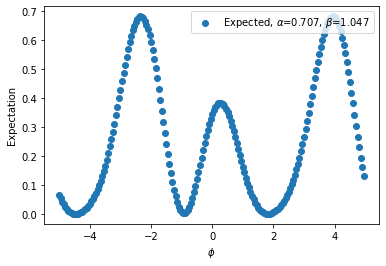

In [17]:
# If we fix the values of alpha and beta, and perform a scan over phi
# from [0, 2π], we can generate a distribution of the number of times
# the system is measured in state |00⟩

# fix two values of alpha and beta
a = 1/sqrt(2)
b = pi/3

# loop over phi from -5 to 5
x_values = np.arange(-5, 5, 0.05)
y_expectations = []

for j in x_values:
    # resolve the circuit for different values of phi
    resolver = cirq.ParamResolver({'alpha': a, 'beta': b, 'phi': j})

    # calcuclate the expectation value
    result = cirq.Simulator().simulate(cirq.resolve_parameters(circuit, resolver))
    e = z00.expectation_from_state_vector(result.final_state_vector, {q0:0, q1:1})
    y_expectations.append(e)

print(result)
print(e)

plt.scatter(x_values, y_expectations, label=f'Expected, $\\alpha$={round(a,3)}, $\\beta$={round(b,3)}')
plt.xlabel('$\phi$')
plt.ylabel('Expectation')
plt.legend()
plt.show()

In [18]:
z00

cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.GridQubit(0, 1), cirq.Z), (cirq.GridQubit(0, 0), cirq.Z)}): (0.25+0j), frozenset({(cirq.GridQubit(0, 0), cirq.Z)}): (0.25+0j), frozenset({(cirq.GridQubit(0, 1), cirq.Z)}): (0.25+0j), frozenset(): (0.25+0j)}))

In [19]:
z00.expectation_from_state_vector(result.final_state_vector, {q0:0, q1:1})

(0.130918700248003+0j)

In [20]:
result.final_state_vector

array([ 0.25667757+0.25502023j, -0.39576927-0.2607826j ,
       -0.33476508+0.24268252j, -0.50486577+0.4675345j ], dtype=complex64)

### Decomposing the circuit

In [21]:
# Input qubits with rotations by the angle \phi
input_circuit = cirq.Circuit([
                cirq.rx(phi)(q0),
                cirq.ry(-2*phi)(q1)
                ])
input_circuit

(0, 0): ───Rx(phi)──────

(0, 1): ───Ry(-2*phi)───

In [22]:
# The circuit that is going to be my model
# a.k.a given some inputs (rotated qubits) these will be entangled and
# rotated by fixed values that we want to learn
model_circuit = cirq.Circuit([
                cirq.H(q0),
                cirq.CNOT(q0,q1),
                cirq.rx(alpha)(q0),
                cirq.ry(beta)(q1),
              ])
model_circuit

(0, 0): ───H───@───Rx(alpha)───
               │
(0, 1): ───────X───Ry(beta)────

In [23]:
# building a keras model
# the input is the input_circuit 
# Parameterized Quantum Circuit - PQC
# the PQC outputs the expectation to be in state |00> from the model circuit, given the input circuit
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(model_circuit, z00),
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.trainable_variables

[<tf.Variable 'parameters:0' shape=(2,) dtype=float32, numpy=array([4.175567 , 2.7709274], dtype=float32)>]

In [26]:
# convert the input circuits (one circuit per value of phi) into tensors
# generate a series of input circuits, with different x values (values of phi)
input_circuits =  tfq.convert_to_tensor([cirq.resolve_parameters(input_circuit, cirq.ParamResolver({'phi': x}))] for x in x_values)
print(input_circuits[:3])

tf.Tensor(
[[b'\n\x0e\n\x0ctfq_gate_set\x12\x99\x02\x08\x01\x12\x94\x02\n\x87\x01\n\x04\n\x02XP\x12\x16\n\x0econtrol_qubits\x12\x04\n\x02\x1a\x00\x12\x13\n\x08exponent\x12\x07\n\x05\r\xe1\xb7\xcb\xbf\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\xbf\x12\x16\n\x0econtrol_values\x12\x04\n\x02\x1a\x00\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x1a\x05\x12\x030_0\n\x87\x01\n\x04\n\x02YP\x12\x16\n\x0econtrol_qubits\x12\x04\n\x02\x1a\x00\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\xbf\x12\x16\n\x0econtrol_values\x12\x04\n\x02\x1a\x00\x12\x13\n\x08exponent\x12\x07\n\x05\r\xe5\xb7K@\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x1a\x05\x12\x030_1']
 [b'\n\x0e\n\x0ctfq_gate_set\x12\x99\x02\x08\x01\x12\x94\x02\n\x87\x01\n\x04\n\x02XP\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x16\n\x0econtrol_values\x12\x04\n\x02\x1a\x00\x12\x13\n\x08exponent\x12\x07\n\x05\r`\xae\xc9\xbf\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\xbf\x12\

In [27]:
x_values[:5]

array([-5.  , -4.95, -4.9 , -4.85, -4.8 ])

In [28]:
len(x_values)

200

In [29]:
input_circuits.shape

TensorShape([200, 1])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


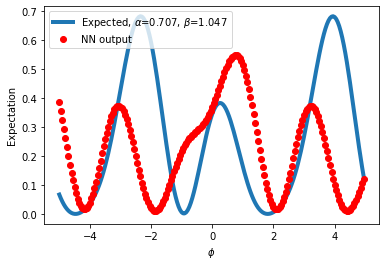

In [30]:
# test the model with randomly initialised values of alpha and beta given the input circuits
y_test = model([input_circuits]).numpy()

# plot how a randomly initiated model compares with the expected
plt.plot(x_values, y_expectations, lw=4, label=f'Expected, $\\alpha$={round(a,3)}, $\\beta$={round(b,3)}')
plt.plot(x_values, y_test,'ro', label='NN output')
plt.xlabel('$\phi$')
plt.ylabel('Expectation')
plt.legend()
plt.show()

In [31]:
# compile the model, using a basic Adam optimizer and MSE loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [32]:
# model can be fitted given now the y_expected from the original expectations
# (this could easily be the original 'measurements' distribution instead)
y_expected = np.array(y_expectations)
history = model.fit(input_circuits, y_expected,
                    epochs=25, verbose=1)
type(history)

Epoch 1/25
7/7 [==============================] - 1s 8ms/step - loss: 0.0769
Epoch 2/25
7/7 [==============================] - 0s 11ms/step - loss: 0.0806
Epoch 3/25
7/7 [==============================] - 0s 10ms/step - loss: 0.0692
Epoch 4/25
7/7 [==============================] - 0s 9ms/step - loss: 0.0669
Epoch 5/25
7/7 [==============================] - 0s 9ms/step - loss: 0.0639
Epoch 6/25
7/7 [==============================] - 0s 9ms/step - loss: 0.0704
Epoch 7/25
7/7 [==============================] - 0s 11ms/step - loss: 0.0614
Epoch 8/25
7/7 [==============================] - 0s 9ms/step - loss: 0.0598
Epoch 9/25
7/7 [==============================] - 0s 9ms/step - loss: 0.0514
Epoch 10/25
7/7 [==============================] - 0s 10ms/step - loss: 0.0474
Epoch 11/25
7/7 [==============================] - 0s 10ms/step - loss: 0.0453
Epoch 12/25
7/7 [==============================] - 0s 10ms/step - loss: 0.0400
Epoch 13/25
7/7 [==============================] - 0s 9ms/step - lo

tensorflow.python.keras.callbacks.History

In [33]:
history.params

{'epochs': 25, 'steps': 7, 'verbose': 1}

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


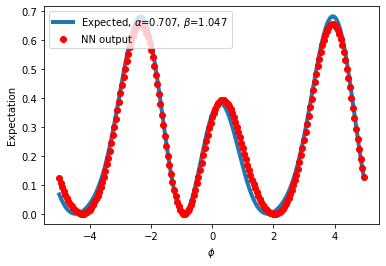

In [34]:
# test the model 
y_test = model([input_circuits]).numpy()

# plot how a randomly initiated model compares with the expected
plt.plot(x_values, y_expected, lw=4, label=f'Expected, $\\alpha$={round(a,3)}, $\\beta$={round(b,3)}')
plt.plot(x_values, y_test,'ro', label='NN output')
plt.xlabel('$\phi$')
plt.ylabel('Expectation')
plt.legend()
plt.show()